<a href="https://colab.research.google.com/github/limited-fion/deep-learning-cw/blob/master/06_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up libraries and functions

In [51]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility

from keras import regularizers
from keras import initializers
from keras import metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Conv2D, Reshape, Flatten, BatchNormalization, UpSampling2D

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist, cifar10
from tensorflow.keras.layers.experimental import preprocessing
from skimage.transform import resize
from sklearn.decomposition import PCA

from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from google.colab import drive
import os
drive.mount('/content/drive')

!wget https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf

font_files = fm.findSystemFonts()

# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)

# Use your new font on all your plots.
plt.rc('font', family='serif')

def predict_representation(model, data, layer_name='representation'):
  ## We form a new model. Instead of doing \psi\phi(x), we only take \phi(x)
  ## To do so, we use the layer name
  intermediate_layer_model = Model(inputs=model.input,
                                   outputs=model.get_layer(layer_name).output)
  representation = intermediate_layer_model.predict(data)
  representation = representation.reshape(representation.shape[0], -1)
  return representation

def plot_representation_label(representation, labels, plot3d=0):
  ## Function used to plot the representation vectors and assign different 
  ## colors to the different classes

  # First create the figure
  fig, ax = plt.subplots(figsize=(10,6))
  # In case representation dimension is 3, we can plot in a 3d projection too
  if plot3d:
    ax = fig.add_subplot(111, projection='3d')
    
  # Check number of labels to separate by colors
  n_labels = labels.max() + 1
  # Color map, and give different colors to every label
  cm = plt.get_cmap('gist_rainbow')
  ax.set_prop_cycle(color=[cm(1.*i/(n_labels)) for i in range(n_labels)])
  # Loop is to plot different color for each label
  for l in range(n_labels):
    # Only select indices for corresponding label
    ind = labels == l
    if plot3d:
      ax.scatter(representation[ind, 0], representation[ind, 1], 
                 representation[ind, 2], label=str(l))
    else:
      ax.scatter(representation[ind, 0], representation[ind, 1], label=str(l))
  ax.legend()
  plt.title('Features in the representation space with corresponding label')
  plt.show()
  return fig, ax

def plot_recons_original(image, label, model, size_image=(28,28)):
  ## Function used to plot image x and reconstructed image \psi\phi(x)
  # Reshape (just in case) and predict using model
  if len(image.shape) == 1:
    image = image.reshape(1, -1)
  reconst_image = model.predict(image)
  # Evaluate MSE to also report it in the image
  mse = model.evaluate(image, image, verbose=0)
  # Create a figure with 1 row and 2 columns
  plt.subplots(1,2)
  # Select first image in the figure
  ax = plt.subplot(121)
  # Plot image x
  plt.imshow(image.reshape(size_image[0],size_image[1]), cmap='gray')
  # This removes the ticks in the axis
  ax.set_xticks([])
  ax.set_yticks([])
  # Select second image in the figure
  ax = plt.subplot(122)
  # Plot reconstructed image
  plt.imshow(reconst_image.reshape(size_image[0],size_image[1]), cmap='gray')
  # This removes the ticks in the axis
  ax.set_xticks([])
  ax.set_yticks([])
  # Set a title to the current axis (second figure)
  plt.title('MSE of {:.2f}'.format(mse[0]))
  plt.show()

def lr_scheduler(epoch, lr):
    decay_rate = 0.8
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lrate = keras.callbacks.LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor='val_mse', patience=8, restore_best_weights=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2023-03-10 23:39:49--  https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Times New Roman.ttf.3’

Times New Roman.ttf     [ <=>                ] 142.34K  --.-KB/s    in 0.02s   

2023-03-10 23:39:49 (6.18 MB/s) - ‘Times New Roman.ttf.3’ saved [145754]



# Task 1

In [63]:
num_classes = 10

# Use x_test as your validation set
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train= x_train.astype('float32')
x_test= x_test.astype('float32')
x_train /= 255.
x_test /= 255.
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2],1)
x_train_32 = np.zeros((x_train.shape[0], 32,32,1))
x_test_32 = np.zeros((x_test.shape[0], 32,32,1))
# We resize the images
for n in range(x_train.shape[0]):
    x_train_32[n,:,:,:] = resize(x_train[n,:,:,:], (32,32,1), anti_aliasing=True)
for n in range(x_test.shape[0]):
    x_test_32[n,:,:,:] = resize(x_test[n,:,:,:], (32,32,1), anti_aliasing=True)

## Without using any convolutional layer

### 1

In [19]:
### Modify the model here
autoencoder = Sequential()
autoencoder.add(Flatten(input_shape=(32,32,)))
# The representation has dimensionality 10, do not change the dimensionality
autoencoder.add(Dense(10, name='representation'))
autoencoder.add(Dense(32*32))
autoencoder.add(Reshape((32,32,1)))

autoencoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 1024)              0         
                                                                 
 representation (Dense)      (None, 10)                10250     
                                                                 
 dense_9 (Dense)             (None, 1024)              11264     
                                                                 
 reshape_7 (Reshape)         (None, 32, 32, 1)         0         
                                                                 
Total params: 21,514
Trainable params: 21,514
Non-trainable params: 0
_________________________________________________________________


In [22]:
autoencoder.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
# You can modify the number of epochs or other hyperparameters
epochs = 20
history = autoencoder.fit(x_train_32, x_train_32, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(x_test_32,x_test_32))

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 3/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 8/20
469/469 [==============================] - 2s 4ms/step - loss: 0.

### 2

In [74]:
### Modify the model here
autoencoder2 = Sequential()
autoencoder2.add(Flatten(input_shape=(32,32,)))
autoencoder2.add(Dense(512, activation='relu'))
autoencoder2.add(Dense(256, activation='relu'))

# The representation has dimensionality 10, do not change the dimensionality

autoencoder2.add(Dense(10, name='representation'))
autoencoder2.add(Dense(256, activation='relu'))
autoencoder2.add(Dense(512, activation='relu'))
autoencoder2.add(Dense(32*32, activation='sigmoid'))
autoencoder2.add(Reshape((32,32,1)))

autoencoder2.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_25 (Flatten)        (None, 1024)              0         
                                                                 
 dense_51 (Dense)            (None, 512)               524800    
                                                                 
 dense_52 (Dense)            (None, 256)               131328    
                                                                 
 representation (Dense)      (None, 10)                2570      
                                                                 
 dense_53 (Dense)            (None, 256)               2816      
                                                                 
 dense_54 (Dense)            (None, 512)               131584    
                                                                 
 dense_55 (Dense)            (None, 1024)            

In [75]:
autoencoder2.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])

# You can modify the number of epochs or other hyperparameters
epochs = 60
history_nonconv2 = autoencoder2.fit(x_train_32, x_train_32, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(x_test_32,x_test_32), callbacks=[early_stopping])

Epoch 1/60
469/469 [==============================] - 4s 5ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 2/60
469/469 [==============================] - 2s 4ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 3/60
469/469 [==============================] - 2s 4ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 4/60
469/469 [==============================] - 2s 4ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 5/60
469/469 [==============================] - 2s 4ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 6/60
469/469 [==============================] - 2s 4ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 7/60
469/469 [==============================] - 2s 4ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 8/60
469/469 [==============================] - 2s 4ms/step - loss: 0.

## Convolutional autoencoder

### 1

In [54]:
### Modify the model here
### This is an example of a simple/bad convolutional autoencoder
conv_autoencoder = Sequential()
conv_autoencoder.add(Conv2D(32, 3, strides=2, padding='same'))
conv_autoencoder.add(Flatten())
# The representation has dimensionality 10, do not change the dimensionality
conv_autoencoder.add(Dense(10, name='representation'))
conv_autoencoder.add(Dense(1*16*16))
conv_autoencoder.add(Reshape((16,16,1)))
conv_autoencoder.add(UpSampling2D((2, 2)))

conv_autoencoder.build((None,32,32,1))
conv_autoencoder.summary()
conv_autoencoder.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
# You can modify the number of epochs or other hyperparameters
epochs = 20
history = conv_autoencoder.fit(x_train_32, x_train_32, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(x_test_32,x_test_32))

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 16, 16, 32)        320       
                                                                 
 flatten_15 (Flatten)        (None, 8192)              0         
                                                                 
 representation (Dense)      (None, 10)                81930     
                                                                 
 dense_15 (Dense)            (None, 256)               2816      
                                                                 
 reshape_12 (Reshape)        (None, 16, 16, 1)         0         
                                                                 
 up_sampling2d_11 (UpSamplin  (None, 32, 32, 1)        0         
 g2D)                                                            
                                                     

### 2

In [79]:
### Modify the model here
### This is an example of a simple/bad convolutional autoencoder
conv_autoencoder2 = Sequential()
conv_autoencoder2.add(Conv2D(32, 3, strides=2, padding='same', activation='relu'))
conv_autoencoder2.add(Conv2D(64, 3, strides=2, padding='same', activation='relu'))
conv_autoencoder2.add(Conv2D(128, 3, strides=2, padding='same', activation='relu'))
conv_autoencoder2.add(Flatten())
# The representation has dimensionality 10, do not change the dimensionality
conv_autoencoder2.add(Dense(10, name='representation'))
conv_autoencoder2.add(Dense(1*16*16))
conv_autoencoder2.add(Reshape((16,16,1)))
conv_autoencoder2.add(Conv2D(64, 3, strides=1, padding='same', activation='relu'))
conv_autoencoder2.add(UpSampling2D((2, 2)))
conv_autoencoder2.add(Conv2D(32, 3, strides=1, padding='same', activation='relu'))
conv_autoencoder2.add(Conv2D(1, 3, strides=1, padding='same', activation='sigmoid'))

conv_autoencoder2.build((None,32,32,1))
conv_autoencoder2.summary()
conv_autoencoder2.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
# You can modify the number of epochs or other hyperparameters
epochs = 80
history_conv2 = conv_autoencoder2.fit(x_train_32, x_train_32, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(x_test_32,x_test_32), callbacks=[early_stopping])

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 16, 16, 32)        320       
                                                                 
 conv2d_46 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_47 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_26 (Flatten)        (None, 2048)              0         
                                                                 
 representation (Dense)      (None, 10)                20490     
                                                                 
 dense_57 (Dense)            (None, 256)               2816      
                                                                 
 reshape_26 (Reshape)        (None, 16, 16, 1)       

## Classifier 

### 1

In [7]:
pca = PCA(n_components=10)
pca = pca.fit(x_train_32.reshape(x_train_32.shape[0], -1))

## We compute the representations for the different methods
representation_pca_train = pca.transform(x_train_32.reshape(x_train_32.shape[0], -1))
representation_pca_test = pca.transform(x_test_32.reshape(x_test_32.shape[0], -1))
# predict_representation is defined at the beginning of this notebook
representation_auto_train = predict_representation(autoencoder, x_train_32)
representation_auto_test = predict_representation(autoencoder, x_test_32)
representation_conv_auto_train = predict_representation(conv_autoencoder, x_train_32)
representation_conv_auto_test = predict_representation(conv_autoencoder, x_test_32)

# We compute the MSE for the PCA method
reconst_train = pca.inverse_transform(representation_pca_train).reshape(x_train_32.shape[0], 32,32,1)
train_mse_pca = ((reconst_train - x_train_32)**2).mean()

reconst_test = pca.inverse_transform(representation_pca_test).reshape(x_test_32.shape[0], 32,32,1)
test_mse_pca = ((reconst_test - x_test_32)**2).mean()
# We print the MSE for PCA, which you need to include on the table
print("PCA MSE: x_train {:.4f} - x_test {:.4f}".format(train_mse_pca, test_mse_pca))


num_classes = 10

### Use always this linear classifier, do not modify it
classifier = Sequential()
classifier.add(Dense(10, activation='softmax'))
classifier.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
epochs = 30
history = classifier.fit(representation_pca_train, y_train, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(representation_pca_test,y_test))


313/313 [==============================] - 0s 1ms/step
PCA MSE: x_train 0.0258 - x_test 0.0256
Epoch 1/30
469/469 [==============================] - 2s 3ms/step - loss: 1.9771 - acc: 0.3945 - val_loss: 1.2304 - val_acc: 0.5889
Epoch 2/30
469/469 [==============================] - 1s 3ms/step - loss: 0.9985 - acc: 0.6847 - val_loss: 0.8263 - val_acc: 0.7571
Epoch 3/30
469/469 [==============================] - 1s 3ms/step - loss: 0.7808 - acc: 0.7649 - val_loss: 0.7123 - val_acc: 0.7850
Epoch 4/30
469/469 [==============================] - 1s 3ms/step - loss: 0.7040 - acc: 0.7818 - val_loss: 0.6623 - val_acc: 0.7951
Epoch 5/30
469/469 [==============================] - 1s 3ms/step - loss: 0.6662 - acc: 0.7897 - val_loss: 0.6356 - val_acc: 0.8017
Epoch 6/30
469/469 [==============================] - 1s 3ms/step - loss: 0.6444 - acc: 0.7944 - val_loss: 0.6193 - val_acc: 0.8048
Epoch 7/30
469/469 [==============================] - 1s 3ms/step - loss: 0.6306 - acc: 0.7979 - val_loss: 0.6084

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.014s...
[t-SNE] Computed neighbors for 10000 samples in 1.507s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.563892
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.069153
[t-SNE] KL divergence after 500 iterations: 1.903015


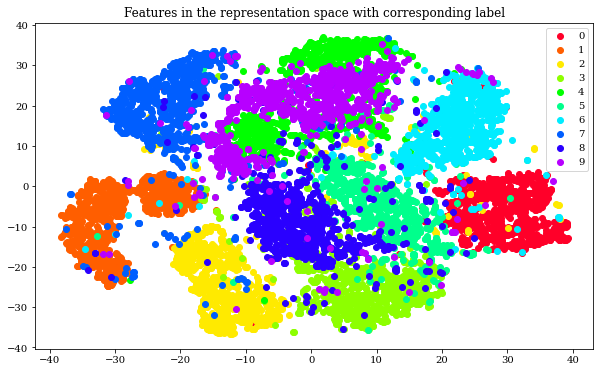

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Features in the representation space with corresponding label'}>)

In [33]:
## We use tSNE for our dimensionality reduction technique so we can
## plot the features using a 2D plot as it leads to nice plots.
## However, tSNE is tricky to use as a general dimensionality reduction method
## for clustering due to issues mentioned here: https://distill.pub/2016/misread-tsne/
## TSNE: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
## Nice article explaining shortcomings: https://distill.pub/2016/misread-tsne/
from sklearn.manifold import TSNE

## Use these parameters, the plots are highly dependent on perplexity value
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500,n_jobs=8)
representation_tsne = tsne.fit_transform(representation_auto_test)
plot_representation_label(representation_tsne, y_test)

1/1 [==============================] - 0s 25ms/step


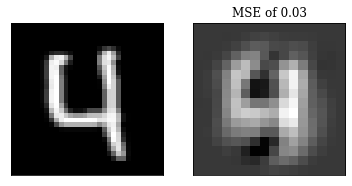

In [36]:
ind = np.random.randint(x_test.shape[0] -  1)
## The function below is defined in the tutorial
plot_recons_original(np.expand_dims(x_test_32[ind],0), y_test[ind], conv_autoencoder, size_image=(32,32))

### auto


In [86]:
autoencoderName = autoencoder2
conv_autoencoderName = conv_autoencoder2

pca = PCA(n_components=10)
pca = pca.fit(x_train_32.reshape(x_train_32.shape[0], -1))

## We compute the representations for the different methods
representation_pca_train = pca.transform(x_train_32.reshape(x_train_32.shape[0], -1))
representation_pca_test = pca.transform(x_test_32.reshape(x_test_32.shape[0], -1))
# predict_representation is defined at the beginning of this notebook
representation_auto_train = predict_representation(autoencoder2, x_train_32)
representation_auto_test = predict_representation(autoencoder2, x_test_32)
representation_conv_auto_train = predict_representation(conv_autoencoder2, x_train_32)
representation_conv_auto_test = predict_representation(conv_autoencoder2, x_test_32)

# We compute the MSE for the PCA method
reconst_train = pca.inverse_transform(representation_pca_train).reshape(x_train_32.shape[0], 32,32,1)
train_mse_pca = ((reconst_train - x_train_32)**2).mean()

reconst_test = pca.inverse_transform(representation_pca_test).reshape(x_test_32.shape[0], 32,32,1)
test_mse_pca = ((reconst_test - x_test_32)**2).mean()
# We print the MSE for PCA, which you need to include on the table
print("PCA MSE: x_train {:.4f} - x_test {:.4f}".format(train_mse_pca, test_mse_pca))


num_classes = 10

### Use always this linear classifier, do not modify it
classifier = Sequential()
classifier.add(Dense(10, activation='softmax'))
classifier.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
epochs = 30
history = classifier.fit(representation_auto_train, y_train, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(representation_auto_test,y_test))


313/313 [==============================] - 1s 2ms/step
PCA MSE: x_train 0.0258 - x_test 0.0256
Epoch 1/30
469/469 [==============================] - 2s 3ms/step - loss: 2.1169 - acc: 0.5215 - val_loss: 0.6526 - val_acc: 0.8084
Epoch 2/30
469/469 [==============================] - 1s 3ms/step - loss: 0.4735 - acc: 0.8712 - val_loss: 0.3578 - val_acc: 0.9079
Epoch 3/30
469/469 [==============================] - 1s 3ms/step - loss: 0.3247 - acc: 0.9157 - val_loss: 0.2897 - val_acc: 0.9256
Epoch 4/30
469/469 [==============================] - 1s 3ms/step - loss: 0.2776 - acc: 0.9275 - val_loss: 0.2620 - val_acc: 0.9290
Epoch 5/30
469/469 [==============================] - 1s 3ms/step - loss: 0.2559 - acc: 0.9318 - val_loss: 0.2472 - val_acc: 0.9310
Epoch 6/30
469/469 [==============================] - 1s 3ms/step - loss: 0.2437 - acc: 0.9345 - val_loss: 0.2377 - val_acc: 0.9333
Epoch 7/30
469/469 [==============================] - 1s 3ms/step - loss: 0.2359 - acc: 0.9354 - val_loss: 0.2329

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.014s...
[t-SNE] Computed neighbors for 10000 samples in 0.977s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.319011
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.692688
[t-SNE] KL divergence after 500 iterations: 1.815859


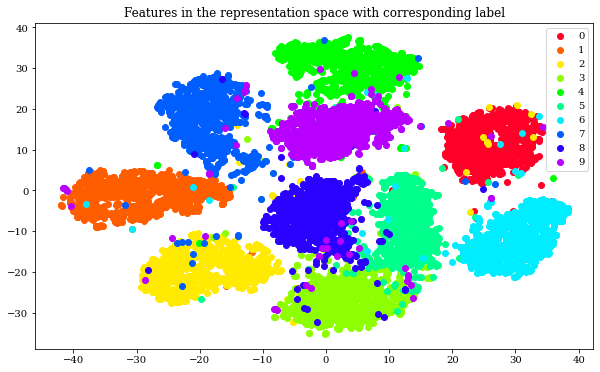

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Features in the representation space with corresponding label'}>)

In [84]:
## We use tSNE for our dimensionality reduction technique so we can
## plot the features using a 2D plot as it leads to nice plots.
## However, tSNE is tricky to use as a general dimensionality reduction method
## for clustering due to issues mentioned here: https://distill.pub/2016/misread-tsne/
## TSNE: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
## Nice article explaining shortcomings: https://distill.pub/2016/misread-tsne/
from sklearn.manifold import TSNE

## Use these parameters, the plots are highly dependent on perplexity value
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500,n_jobs=8)
representation_tsne = tsne.fit_transform(representation_auto_test)
plot_representation_label(representation_tsne, y_test)

1/1 [==============================] - 0s 96ms/step


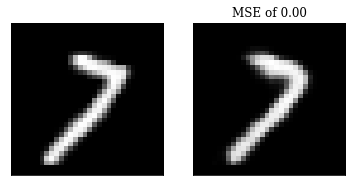

In [90]:
ind = np.random.randint(x_test.shape[0] -  1)
## The function below is defined in the tutorial
plot_recons_original(np.expand_dims(x_test_32[ind],0), y_test[ind], autoencoder2, size_image=(32,32))

### conv_auto

In [87]:
pca = PCA(n_components=10)
pca = pca.fit(x_train_32.reshape(x_train_32.shape[0], -1))

## We compute the representations for the different methods
representation_pca_train = pca.transform(x_train_32.reshape(x_train_32.shape[0], -1))
representation_pca_test = pca.transform(x_test_32.reshape(x_test_32.shape[0], -1))
# predict_representation is defined at the beginning of this notebook
representation_auto_train = predict_representation(autoencoder2, x_train_32)
representation_auto_test = predict_representation(autoencoder2, x_test_32)
representation_conv_auto_train = predict_representation(conv_autoencoder2, x_train_32)
representation_conv_auto_test = predict_representation(conv_autoencoder2, x_test_32)

# We compute the MSE for the PCA method
reconst_train = pca.inverse_transform(representation_pca_train).reshape(x_train_32.shape[0], 32,32,1)
train_mse_pca = ((reconst_train - x_train_32)**2).mean()

reconst_test = pca.inverse_transform(representation_pca_test).reshape(x_test_32.shape[0], 32,32,1)
test_mse_pca = ((reconst_test - x_test_32)**2).mean()
# We print the MSE for PCA, which you need to include on the table
print("PCA MSE: x_train {:.4f} - x_test {:.4f}".format(train_mse_pca, test_mse_pca))


num_classes = 10

### Use always this linear classifier, do not modify it
classifier = Sequential()
classifier.add(Dense(10, activation='softmax'))
classifier.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
epochs = 30
history = classifier.fit(representation_conv_auto_train, y_train, batch_size=128,
          epochs=epochs, verbose=1, validation_data=(representation_conv_auto_test,y_test))


313/313 [==============================] - 1s 2ms/step
PCA MSE: x_train 0.0258 - x_test 0.0256
Epoch 1/30
469/469 [==============================] - 2s 3ms/step - loss: 3.9968 - acc: 0.2094 - val_loss: 1.4092 - val_acc: 0.5665
Epoch 2/30
469/469 [==============================] - 1s 2ms/step - loss: 0.8963 - acc: 0.7416 - val_loss: 0.5485 - val_acc: 0.8653
Epoch 3/30
469/469 [==============================] - 1s 3ms/step - loss: 0.4764 - acc: 0.8808 - val_loss: 0.3795 - val_acc: 0.9095
Epoch 4/30
469/469 [==============================] - 1s 3ms/step - loss: 0.3626 - acc: 0.9101 - val_loss: 0.3128 - val_acc: 0.9267
Epoch 5/30
469/469 [==============================] - 1s 3ms/step - loss: 0.3095 - acc: 0.9228 - val_loss: 0.2755 - val_acc: 0.9311
Epoch 6/30
469/469 [==============================] - 2s 3ms/step - loss: 0.2774 - acc: 0.9301 - val_loss: 0.2510 - val_acc: 0.9362
Epoch 7/30
469/469 [==============================] - 1s 3ms/step - loss: 0.2554 - acc: 0.9344 - val_loss: 0.2338

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 1.415s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.319011
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.690323
[t-SNE] KL divergence after 500 iterations: 1.816018


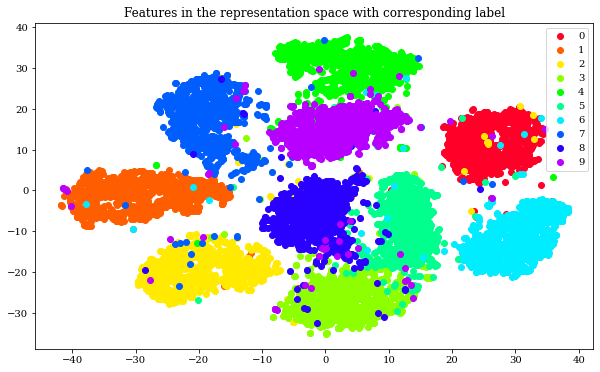

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Features in the representation space with corresponding label'}>)

In [88]:
## We use tSNE for our dimensionality reduction technique so we can
## plot the features using a 2D plot as it leads to nice plots.
## However, tSNE is tricky to use as a general dimensionality reduction method
## for clustering due to issues mentioned here: https://distill.pub/2016/misread-tsne/
## TSNE: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
## Nice article explaining shortcomings: https://distill.pub/2016/misread-tsne/
from sklearn.manifold import TSNE

## Use these parameters, the plots are highly dependent on perplexity value
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500,n_jobs=8)
representation_tsne = tsne.fit_transform(representation_auto_test)
plot_representation_label(representation_tsne, y_test)

1/1 [==============================] - 0s 25ms/step


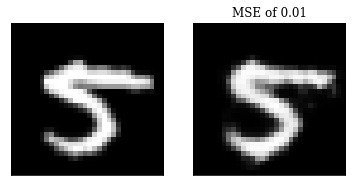

In [89]:
ind = np.random.randint(x_test.shape[0] -  1)
## The function below is defined in the tutorial
plot_recons_original(np.expand_dims(x_test_32[ind],0), y_test[ind], conv_autoencoder2, size_image=(32,32))

# Task 3


# Libraries and functions

In [1]:
from keras import backend as K
import time 
import cv2
import numpy as np 
from keras.layers import Input, concatenate , Conv2D, Dropout, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
import matplotlib.pyplot as plt

# download TinyImageNet
! git clone https://github.com/seshuad/IMagenet

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict

def get_data(id_dict, split):

    print('starting loading data')
    data = []
    t = time.time()
    if split == 'train':
      total_im = 25000
      for key, value in id_dict.items():
          data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450)]
          if len(data) > total_im:
            break
    else:
      total_im = 2500
      for line in open('IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
          img_name, class_id = line.split('\t')[:2]
          data.append(cv2.imread('IMagenet/tiny-imagenet-200/val/images/{}'.format(img_name)))
          if len(data) > total_im:
            break
    print('finished loading data, in {} seconds'.format(time.time() - t))
    data = np.array(data).astype('float32')
    data /= 255.
    return data

def UNet_model():
  
  inputs = Input((64,64,3))
  
  ## Encoder part
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate=0.5)(conv5)

  ## Now the decoder starts
  up6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    
  conv10 = Conv2D(3, 3,  padding = 'same')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  
  return model

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 40.68 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Updating files: 100% (120206/120206), done.


## MSE


In [4]:
def custom_loss(true_values, predicted_values):
    return K.mean(K.square(predicted_values - true_values), axis=-1)

starting loading data
finished loading data, in 2.392313241958618 seconds
starting loading data
finished loading data, in 0.23841071128845215 seconds


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
178/178 [==============================] - 81s 371ms/step - loss: 0.0554 - mse: 0.0554 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 2/10
178/178 [==============================] - 65s 365ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 3/10
178/178 [==============================] - 65s 363ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 4/10
178/178 [==============================] - 64s 362ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 5/10
178/178 [==============================] - 64s 362ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 6/10
178/178 [==============================] - 65s 363ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 7/10
178/178 [==============================] - 65s 363ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 8/10
178/178 [==============================] - 6

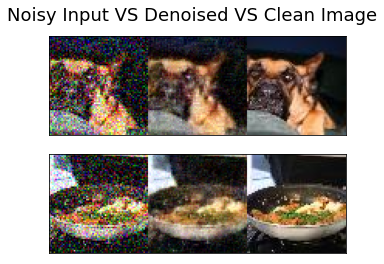

In [2]:
x_train = get_data(get_id_dictionary(), 'train')
x_test = get_data(get_id_dictionary(), 'test')

# Add noise
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.2)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.2)

model = UNet_model()
model.compile(optimizer = Adam(lr=1e-4), loss = custom_loss, metrics = ['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = model.evaluate(x_test_noise, x_test)
print('MSE (trained with Custom loss): ', mse)

idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    im = cv2.cvtColor(im.astype(np.float32), cv2.COLOR_BGR2RGB)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

## MAE

starting loading data
finished loading data, in 2.541815757751465 seconds
starting loading data
finished loading data, in 0.2294936180114746 seconds
Epoch 1/10
178/178 [==============================] - 86s 390ms/step - loss: 0.1501 - mse: 0.0754 - val_loss: 0.0874 - val_mse: 0.0129
Epoch 2/10
178/178 [==============================] - 65s 363ms/step - loss: 0.0784 - mse: 0.0105 - val_loss: 0.0739 - val_mse: 0.0094
Epoch 3/10
178/178 [==============================] - 65s 365ms/step - loss: 0.0699 - mse: 0.0085 - val_loss: 0.0684 - val_mse: 0.0081
Epoch 4/10
178/178 [==============================] - 65s 365ms/step - loss: 0.0654 - mse: 0.0075 - val_loss: 0.0652 - val_mse: 0.0074
Epoch 5/10
178/178 [==============================] - 65s 366ms/step - loss: 0.0624 - mse: 0.0068 - val_loss: 0.0642 - val_mse: 0.0071
Epoch 6/10
178/178 [==============================] - 65s 364ms/step - loss: 0.0603 - mse: 0.0064 - val_loss: 0.0617 - val_mse: 0.0066
Epoch 7/10
178/178 [=====================

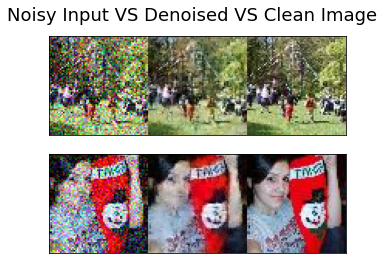

In [8]:
def mae(true_values, predicted_values):
    return K.mean(K.abs(predicted_values - true_values), axis=-1)

x_train = get_data(get_id_dictionary(), 'train')
x_test = get_data(get_id_dictionary(), 'test')

# Add noise
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.2)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.2)

model = UNet_model()
model.compile(optimizer = Adam(lr=1e-4), loss = mae, metrics = ['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = model.evaluate(x_test_noise, x_test)
print('MSE (trained with MAE): ', mse)

idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    im = cv2.cvtColor(im.astype(np.float32), cv2.COLOR_BGR2RGB)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

starting loading data
finished loading data, in 2.345947742462158 seconds
starting loading data
finished loading data, in 0.2334904670715332 seconds


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
178/178 [==============================] - 68s 376ms/step - loss: 0.1451 - mse: 0.0833 - val_loss: 0.0845 - val_mse: 0.0122
Epoch 2/10
178/178 [==============================] - 65s 367ms/step - loss: 0.0753 - mse: 0.0098 - val_loss: 0.0714 - val_mse: 0.0088
Epoch 3/10
178/178 [==============================] - 65s 367ms/step - loss: 0.0670 - mse: 0.0078 - val_loss: 0.0671 - val_mse: 0.0077
Epoch 4/10
178/178 [==============================] - 65s 366ms/step - loss: 0.0630 - mse: 0.0069 - val_loss: 0.0634 - val_mse: 0.0070
Epoch 5/10
178/178 [==============================] - 65s 366ms/step - loss: 0.0604 - mse: 0.0064 - val_loss: 0.0612 - val_mse: 0.0065
Epoch 6/10
178/178 [==============================] - 65s 365ms/step - loss: 0.0585 - mse: 0.0061 - val_loss: 0.0595 - val_mse: 0.0062
Epoch 7/10
178/178 [==============================] - 65s 365ms/step - loss: 0.0573 - mse: 0.0058 - val_loss: 0.0580 - val_mse: 0.0060
Epoch 8/10
178/178 [==============================] - 6

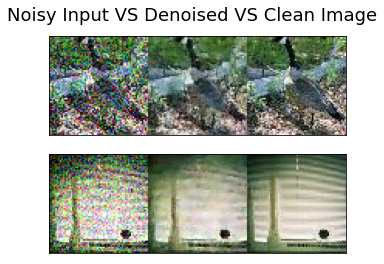

In [10]:
mae = MeanAbsoluteError()

x_train = get_data(get_id_dictionary(), 'train')
x_test = get_data(get_id_dictionary(), 'test')

# Add noise
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.2)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.2)

model = UNet_model()
model.compile(optimizer = Adam(lr=1e-4), loss = mae, metrics = ['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = model.evaluate(x_test_noise, x_test)
print('MSE (trained with MAE): ', mse)

idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    im = cv2.cvtColor(im.astype(np.float32), cv2.COLOR_BGR2RGB)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

## SSIM


starting loading data
finished loading data, in 2.3189849853515625 seconds
starting loading data
finished loading data, in 0.23288631439208984 seconds
Epoch 1/10
178/178 [==============================] - 13s 66ms/step - loss: 0.5243 - mse: 0.0723 - val_loss: 0.3997 - val_mse: 0.0138
Epoch 2/10
178/178 [==============================] - 11s 61ms/step - loss: 0.3749 - mse: 0.0110 - val_loss: 0.3478 - val_mse: 0.0085
Epoch 3/10
178/178 [==============================] - 11s 61ms/step - loss: 0.3316 - mse: 0.0081 - val_loss: 0.3110 - val_mse: 0.0077
Epoch 4/10
178/178 [==============================] - 11s 61ms/step - loss: 0.3007 - mse: 0.0071 - val_loss: 0.2849 - val_mse: 0.0071
Epoch 5/10
178/178 [==============================] - 11s 61ms/step - loss: 0.2831 - mse: 0.0067 - val_loss: 0.2713 - val_mse: 0.0064
Epoch 6/10
178/178 [==============================] - 11s 61ms/step - loss: 0.2713 - mse: 0.0064 - val_loss: 0.2620 - val_mse: 0.0065
Epoch 7/10
178/178 [=========================

1/1 [==============================] - 0s 170ms/step


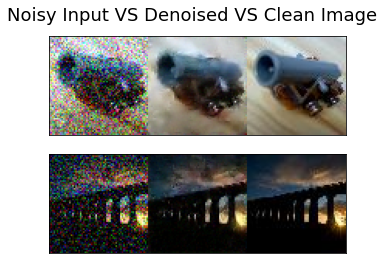

In [8]:
import tensorflow as tf

def ssim_loss(true_values, predicted_values):
    return 1 - K.mean(tf.image.ssim(true_values, predicted_values, max_val=1))

x_train = get_data(get_id_dictionary(), 'train')
x_test = get_data(get_id_dictionary(), 'test')

# Add noise
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.2)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.2)

model = UNet_model()
model.compile(optimizer = Adam(lr=1e-4), loss = ssim_loss, metrics = ['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = model.evaluate(x_test_noise, x_test)
print('MSE (trained with SSIM): ', mse)

idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    im = cv2.cvtColor(im.astype(np.float32), cv2.COLOR_BGR2RGB)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

## MS-SSIM

starting loading data
finished loading data, in 2.325472593307495 seconds
starting loading data
finished loading data, in 0.23488831520080566 seconds


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
178/178 [==============================] - 13s 64ms/step - loss: 0.5590 - mse: 0.7691 - val_loss: 0.4076 - val_mse: 0.0165
Epoch 2/10
178/178 [==============================] - 11s 61ms/step - loss: 0.3797 - mse: 0.0124 - val_loss: 0.3557 - val_mse: 0.0100
Epoch 3/10
178/178 [==============================] - 11s 61ms/step - loss: 0.3352 - mse: 0.0082 - val_loss: 0.3132 - val_mse: 0.0079
Epoch 4/10
178/178 [==============================] - 11s 61ms/step - loss: 0.2963 - mse: 0.0070 - val_loss: 0.2866 - val_mse: 0.0070
Epoch 5/10
178/178 [==============================] - 11s 61ms/step - loss: 0.2761 - mse: 0.0064 - val_loss: 0.2682 - val_mse: 0.0066
Epoch 6/10
178/178 [==============================] - 11s 61ms/step - loss: 0.2643 - mse: 0.0061 - val_loss: 0.2572 - val_mse: 0.0062
Epoch 7/10
178/178 [==============================] - 11s 61ms/step - loss: 0.2573 - mse: 0.0060 - val_loss: 0.2689 - val_mse: 0.0067
Epoch 8/10
178/178 [==============================] - 11s 61ms

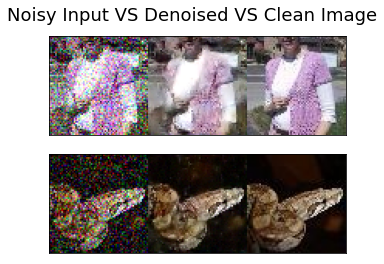

In [23]:
import tensorflow as tf

def multiscale_ssim_loss(true_values, predicted_values):
    return 1 - K.mean(tf.image.ssim(true_values, predicted_values, max_val=1))

x_train = get_data(get_id_dictionary(), 'train')
x_test = get_data(get_id_dictionary(), 'test')

# Add noise
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.2)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.2)

model = UNet_model()
model.compile(optimizer = Adam(lr=1e-4), loss = multiscale_ssim_loss, metrics = ['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = model.evaluate(x_test_noise, x_test)
print('MSE (trained with MS-SSIM): ', mse)

idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    im = cv2.cvtColor(im.astype(np.float32), cv2.COLOR_BGR2RGB)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

## 1/PSNR

starting loading data
finished loading data, in 2.3223214149475098 seconds
starting loading data
finished loading data, in 0.23531389236450195 seconds


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
Tensor("psnr_loss/truediv:0", shape=(), dtype=float32)
Tensor("psnr_loss/truediv:0", shape=(), dtype=float32)
178/178 [==============================] - 12s 61ms/step - loss: 0.0650 - mse: 0.0486 - val_loss: 0.0542 - val_mse: 0.0148
Epoch 2/10
178/178 [==============================] - 10s 58ms/step - loss: 0.0509 - mse: 0.0113 - val_loss: 0.0493 - val_mse: 0.0098
Epoch 3/10
178/178 [==============================] - 10s 58ms/step - loss: 0.0481 - mse: 0.0087 - val_loss: 0.0476 - val_mse: 0.0083
Epoch 4/10
178/178 [==============================] - 10s 58ms/step - loss: 0.0468 - mse: 0.0077 - val_loss: 0.0466 - val_mse: 0.0074
Epoch 5/10
178/178 [==============================] - 10s 58ms/step - loss: 0.0459 - mse: 0.0069 - val_loss: 0.0459 - val_mse: 0.0069
Epoch 6/10
178/178 [==============================] - 10s 58ms/step - loss: 0.0452 - mse: 0.0065 - val_loss: 0.0453 - val_mse: 0.0065
Epoch 7/10
178/178 [==============================] - 10s 58ms/step - loss: 0.0448 - m

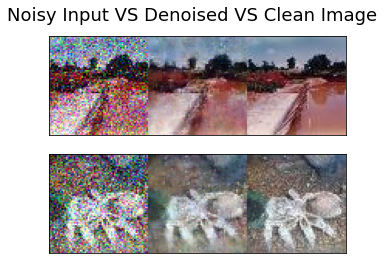

In [19]:
import tensorflow as tf

def psnr_loss(true_values, predicted_values):
    print(1 / K.mean(tf.image.psnr(true_values, predicted_values, max_val=1)))
    return 1 / K.mean(tf.image.psnr(true_values, predicted_values, max_val=1))

x_train = get_data(get_id_dictionary(), 'train')
x_test = get_data(get_id_dictionary(), 'test')

# Add noise
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.2)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.2)

model = UNet_model()
model.compile(optimizer = Adam(lr=1e-4), loss = psnr_loss, metrics = ['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = model.evaluate(x_test_noise, x_test)
print('MSE (trained with MS-SSIM): ', mse)

idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    im = cv2.cvtColor(im.astype(np.float32), cv2.COLOR_BGR2RGB)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])